## Lung Images Preprocessing
### 1.0 Remove the bone in the CT-Scan image to get the only lungs image <br>
Credit to ARNAVJAIN from Kaggle: https://www.kaggle.com/code/arnavkj95/candidate-generation-and-luna16-preprocessing
<br><br>
Steps to do:
1. Convert image to a binary image
2. Remove the blobs connected to the border of the image(using the method 'clear_border()' from skimage.segmentation)
3. Label the images(using method 'label()' from skimage.measure)
4. keep the labels with 2 largest areas which are the lung area(using method 'regionprops()' from skimage.measure to measure the labelled area, after that keep the 2 largest areas and remove the other area)
5. Erosion operation to seperate the lung nodules attached to the blood vessels (method used: 'disk(), binary_erosion()')
6. Closure operationto keep nodules attached to the lung wall (method used: 'disk(), binary_closing()')
7. Fill in the small holes inside the binary mask of lungs (method used: 'roberts() -> to get the edges, ndi.binary_fill_holes() -> to fill the hole')
8. Superimpose叠加 the binary mask on the input image

In [7]:
def get_segmented_lungs(im, plot=False):
    #This funtion segments the lungs from the given 2D slice.

    crop = im.copy()
    #Step 1: Crop the image 
    height,width=im.shape[:2]
    start_row,start_col=int(height*0.15),int(width*0.15)
    end_row,end_col=int(height*0.85),int(width*0.85)
    crop=crop[start_row:end_row,start_col:end_col]

    #Step 2: Convert into a binary image. 
    binary = crop < 150
    
    #Step 3: Remove the blobs connected to the border of the image.
    cleared = clear_border(binary) 
    
    #Step 4: Closure operation with a disk of radius 10. This operation is 
    #to keep nodules attached to the lung wall.
    selem = disk(10)
    closing = binary_closing(cleared, selem)
        
    #Step 5: Label the image.
    label_image = label(closing)
    
    #Step 6: Keep the labels with 2 largest areas.
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    segmented_area = label_image > 0
        
    #Step 7: Erosion operation with a disk of radius 2. This operation is 
    #seperate the lung nodules attached to the blood vessels.
    selem = disk(2)
    erosion = binary_erosion(segmented_area, selem) 
        
    #Step 8: Fill in the small holes inside the binary mask of lungs.
    edges = roberts(erosion)
    fill_holes = ndi.binary_fill_holes(edges)
        
    superimpose = crop.copy()
    #Step 9: Superimpose叠加 the binary mask on the input image.
    get_high_vals = fill_holes == 0
    superimpose[get_high_vals] = 0

    superimpose = cv.resize(superimpose, (IMG_SIZE, IMG_SIZE))    
    
    if plot:
        images = [im, crop, binary, cleared, closing, label_image, segmented_area, erosion, fill_holes, superimpose]
        titles = ['Original Image', 
                 'Step 1: Cropped Image', 
                 'Step 2: Binary image', 
                 'Step 3: Remove blobs', 
                 'Step 4: Closure',
                 'Step 5: Label', 
                 'Step 6: Region On Interest',
                 'Step 7: Erosion',
                 'Step 8: Fill Holes',
                 'Step 9: Result']
        plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 4, fontsize= 50)
    
    return superimpose

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

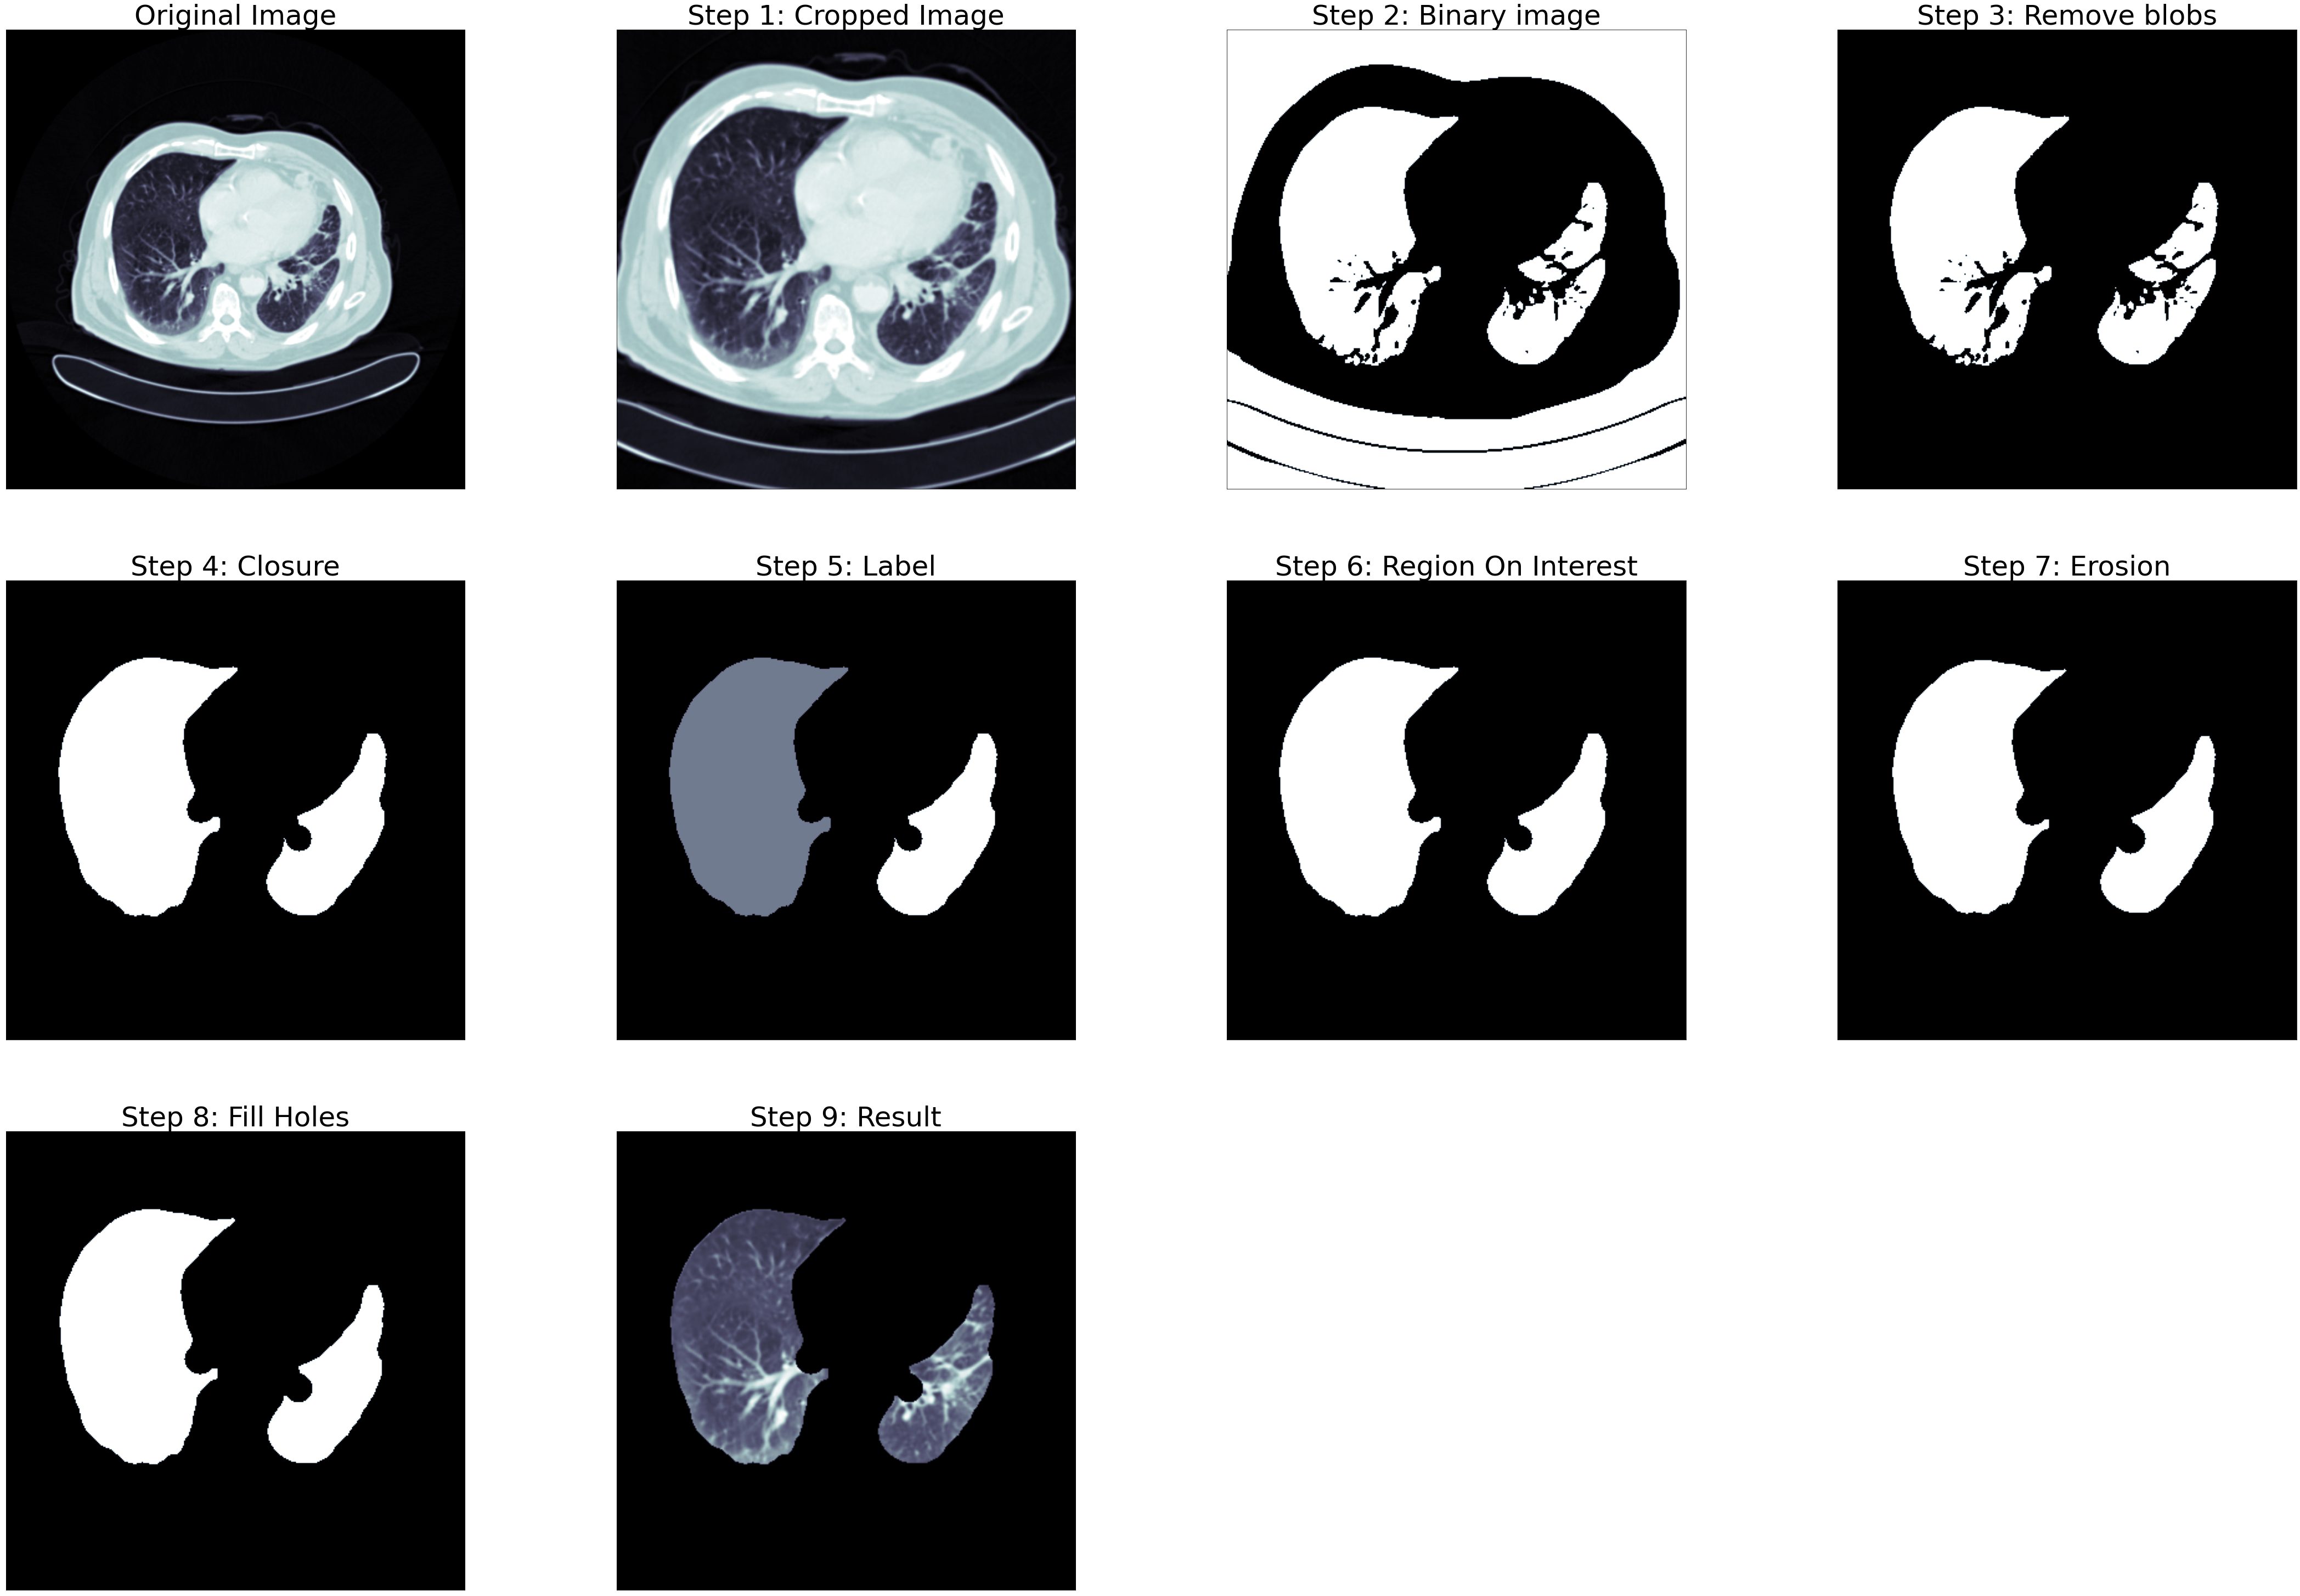

In [8]:
test = X[12].copy()
get_segmented_lungs(test, True)

In [9]:
#Apply to all images
X_segmented = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

for i, img in enumerate(X):
    im = img.copy()
    X_segmented[i] = get_segmented_lungs(im)

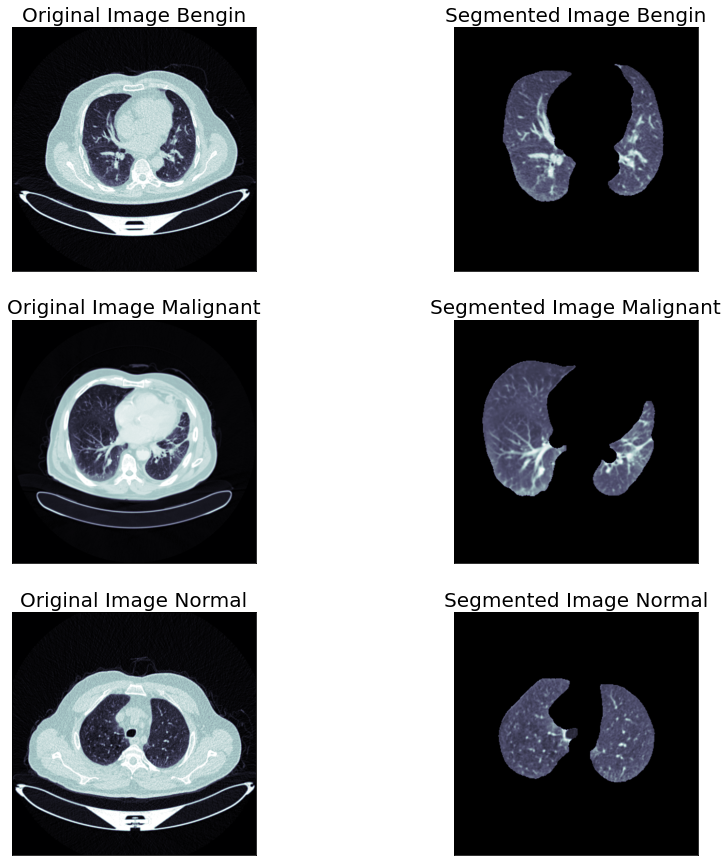

In [10]:
#show the changes of images
images = [X[0], X_segmented[0],
          X[12], X_segmented[12],
          X[24], X_segmented[24]]
titles = ['Original Image ' + y[0], 'Segmented Image ' + y[0], 
         'Original Image ' + y[12], 'Segmented Image ' + y[12], 
         'Original Image ' + y[24], 'Segmented Image ' + y[24]]
plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 2, fontsize= 20, top=3, right=2)

### 2.0 Only remain the nodules of the lung

In [11]:
def get_nodules_lungs(im, plot=False):
    
    #Step 1: Get Nodules in binary
    binary = im < 150
    
    get_high_vals = binary == 0
    
    nodules = im.copy()
    
    nodules[nodules < 150] = 0
    
    if plot == True:
        images = [im, binary, nodules]
        titles = ['Segmented Image', 'Binary Nodules Image', 'Nodules Image']
        plot_img(images, titles, rows = 1, cols = 3)
        
    return nodules

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

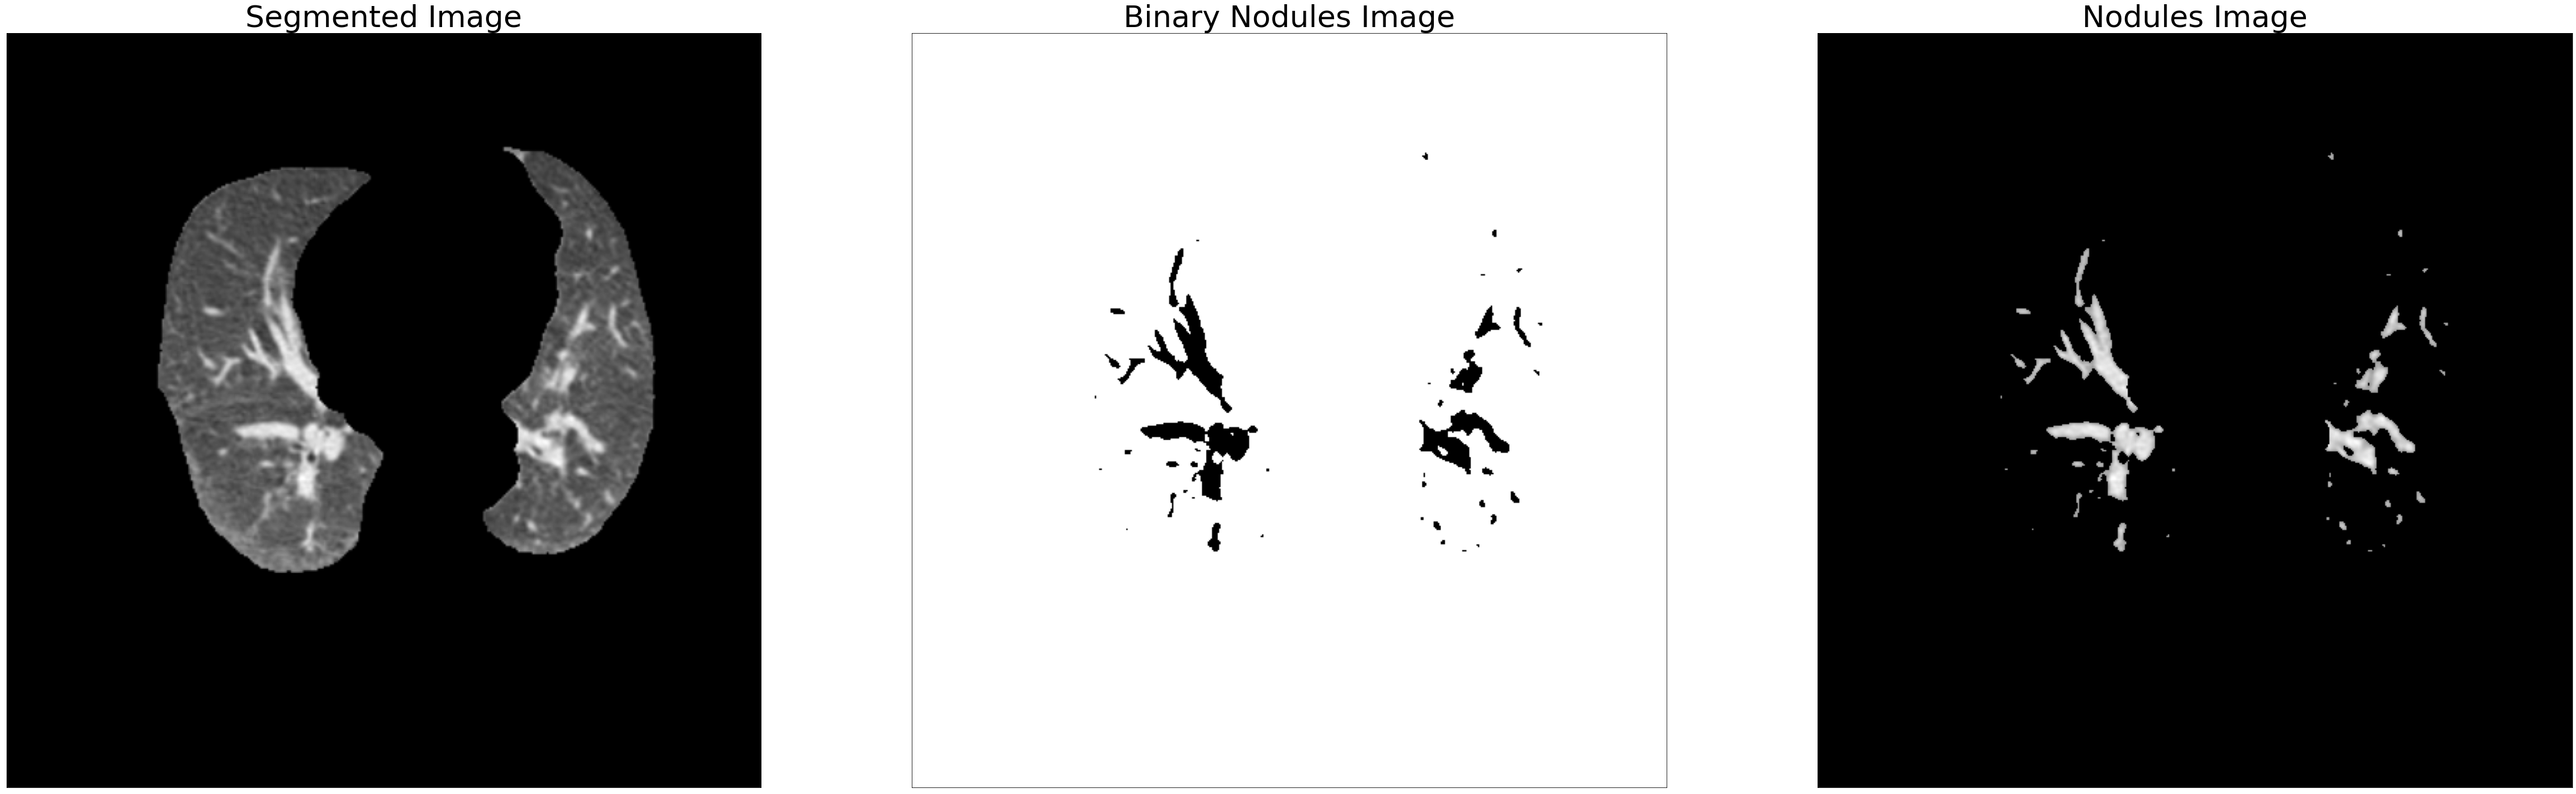

In [12]:
test = X_segmented[0].copy()
get_nodules_lungs(test, True)

In [13]:
X_nodules = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

for i, img in enumerate(X_segmented):
    im = img.copy()
    X_nodules[i] = get_nodules_lungs(im)

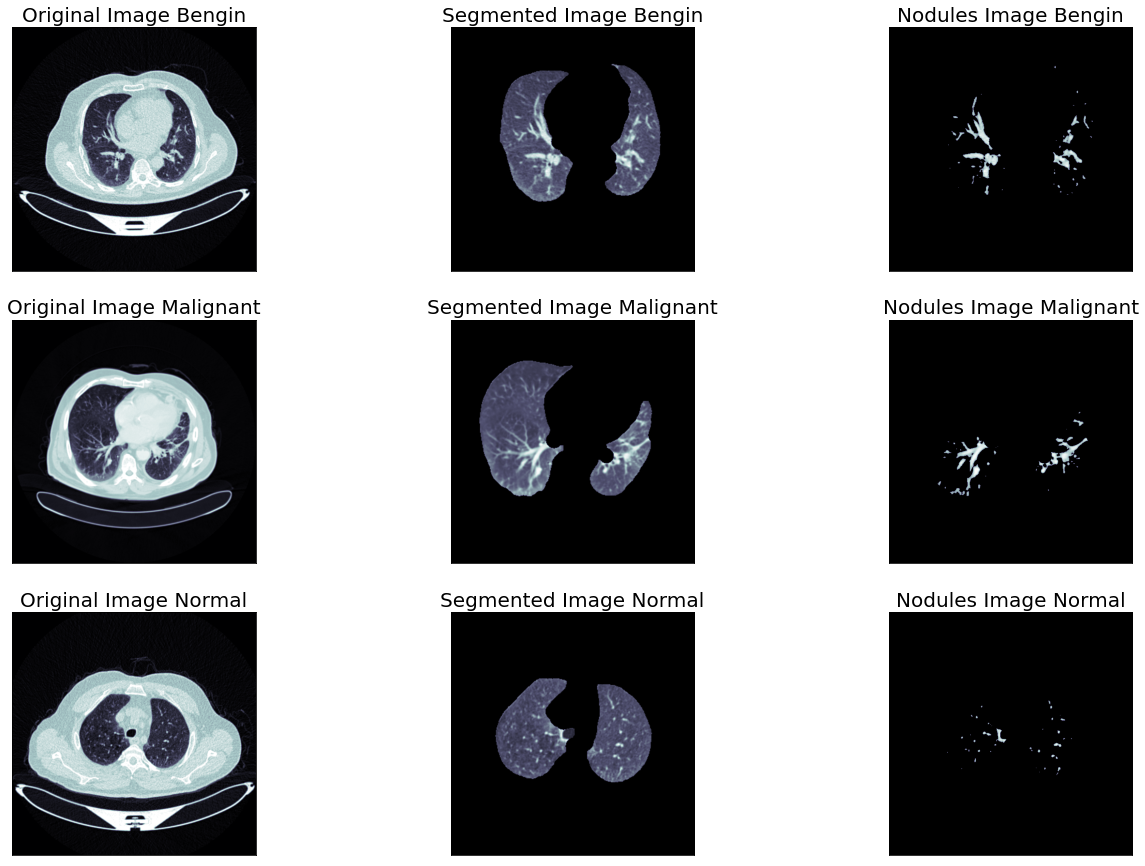

In [14]:
#show the changes of images
images = [X[0], X_segmented[0], X_nodules[0],
          X[12], X_segmented[12], X_nodules[12],
          X[24], X_segmented[24], X_nodules[24]]
titles = ['Original Image ' + y[0], 'Segmented Image ' + y[0], 'Nodules Image ' + y[0],
         'Original Image ' + y[12], 'Segmented Image ' + y[12], 'Nodules Image ' + y[12], 
         'Original Image ' + y[24], 'Segmented Image ' + y[24], 'Nodules Image ' + y[24]]
plot_img(images, titles, camp=plt.cm.bone, rows = 3, cols = 3, fontsize= 20, top=3, right=3)

## 3d plot

In [27]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

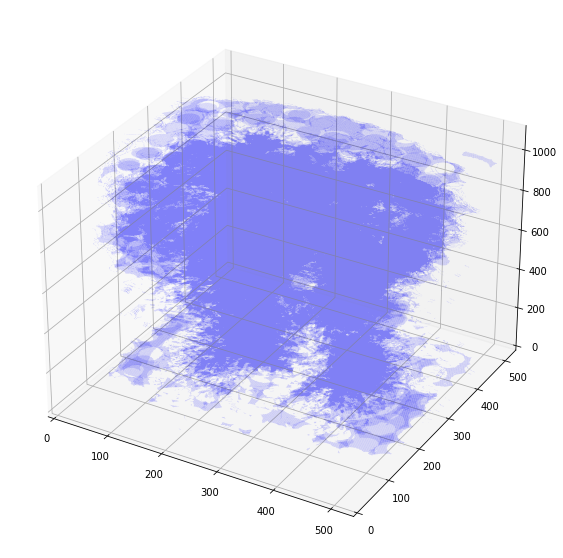

In [28]:
plot_3d(X_nodules, 150)

## Low pass filtering

In [ ]:
#define a function called distance to get the distance between point
def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

#define variable
imgShape = img.shape
D0 = 25 # positive constant
rows, cols = imgShape[:2]
center = (rows/2,cols/2)
base_ideal = np.zeros(imgShape[:2])
base_butterworth = np.zeros(imgShape[:2])
base_gaussian = np.zeros(img.shape[:2])

In [ ]:
#ideal low pass
for c in range(cols):
    for r in range(rows):
        if distance((r,c),center) < D0:
            base_ideal[r,c] = 1

#butterworth low pass
#n is a parameter to affects the clearness of the cutoff between passed and filtered frequencies
n = 20
for c in range(cols):
    for r in range(rows):
        base_butterworth[r,c] = 1/(1+(distance((r,c),center)/D0)**(2*n))

#gaussian low pass
for c in range(cols):
    for r in range(rows):
        base_gaussian[r,c] = np.exp(((-distance((r,c),center)**2)/(2*(D0**2))))

images = [base_ideal, base_butterworth, base_gaussian]
titles = ['ideal low pass', 'butterworth low pass', 'gaussian low pass']
plot_img(images, titles, rows=1, cols=3)

# low pass filtering

In [ ]:
centeredSpectrumX = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

idealCenteredSpectrumX= np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)
butterworthCenteredSpectrumX= np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)
gaussianCenteredSpectrumX= np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

idealX= np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)
butterworthX= np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)
gaussianX= np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

#apply low pass
for i, img in enumerate(X):
    #transform to centered spectrum
    spectrum = np.fft.fft2(img)
    centeredSpectrum = np.fft.fftshift(spectrum)
    
    #apply low pass
    idealCenteredSpectrum = centeredSpectrum * base_ideal
    butterworthCenteredSpectrum = centeredSpectrum * base_butterworth
    gaussianCenteredSpectrum = centeredSpectrum * base_gaussian
    
    #transform inverse(back to ori image but applied low pass filtering)
    ideal_ifshift = np.fft.ifftshift(idealCenteredSpectrum)
    butterworth_ifshift = np.fft.ifftshift(butterworthCenteredSpectrum)
    gaussian_ifshift = np.fft.ifftshift(gaussianCenteredSpectrum)
    
    #img
    back_ideal = np.fft.ifft2(ideal_ifshift)
    back_butterworth = np.fft.ifft2(butterworth_ifshift)
    back_gaussian = np.fft.ifft2(gaussian_ifshift)
    
    #center spectrum
    centeredSpectrumX[i] = np.log(1+np.abs(centeredSpectrum))
    
    #low pass centered spectrumx
    idealCenteredSpectrumX[i] = np.log(1+np.abs(idealCenteredSpectrum))
    butterworthCenteredSpectrumX[i] = np.log(1+np.abs(butterworthCenteredSpectrum))
    gaussianCenteredSpectrumX[i] = np.log(1+np.abs(gaussianCenteredSpectrum))
    
    #converted images
    idealX[i] = np.abs(back_ideal)
    butterworthX[i] = np.abs(back_butterworth)
    gaussianX[i] = np.abs(back_gaussian)

In [ ]:
base_ideal.shape

In [ ]:
images = [X[0], X[24], X[48], 
          X[72], X[96], X[120],
          centeredSpectrumX[0], centeredSpectrumX[24], centeredSpectrumX[48],
          centeredSpectrumX[72], centeredSpectrumX[96], centeredSpectrumX[120],
          idealCenteredSpectrumX[0], idealCenteredSpectrumX[24], idealCenteredSpectrumX[48], 
          idealCenteredSpectrumX[72], idealCenteredSpectrumX[96], idealCenteredSpectrumX[120], 
          butterworthCenteredSpectrumX[0], butterworthCenteredSpectrumX[24], butterworthCenteredSpectrumX[48], 
          butterworthCenteredSpectrumX[72], butterworthCenteredSpectrumX[96], butterworthCenteredSpectrumX[120],
          gaussianCenteredSpectrumX[0], gaussianCenteredSpectrumX[24], gaussianCenteredSpectrumX[48],
          gaussianCenteredSpectrumX[72], gaussianCenteredSpectrumX[96], gaussianCenteredSpectrumX[120],
          idealX[0], idealX[24], idealX[48],
          idealX[72], idealX[96], idealX[120],
          butterworthX[0], butterworthX[24], butterworthX[48],
          butterworthX[72], butterworthX[96], butterworthX[120],
          gaussianX[0], gaussianX[24], gaussianX[48],
          gaussianX[72], gaussianX[96], gaussianX[120]]
titles = ['Original_'+y[0], 'Original_'+y[24], 'Original_'+y[48],
          'Original_'+y[72], 'Original_'+y[96], 'Original_'+y[120],
          'CenteredSpectrum_'+y[0], 'CenteredSpectrum_'+y[24], 'CenteredSpectrum_'+y[48], 
          'CenteredSpectrum_'+y[72], 'CenteredSpectrum_'+y[96], 'CenteredSpectrum_'+y[120], 
          'idealCenteredSpectrum_'+y[0], 'idealCenteredSpectrum_'+y[24], 'idealCenteredSpectrum_'+y[48],
          'idealCenteredSpectrum_'+y[72], 'idealCenteredSpectrum_'+y[96], 'idealCenteredSpectrum_'+y[120],
          'butterworthCenteredSpectrum_'+y[0], 'butterworthCenteredSpectrum_'+y[24], 'butterworthCenteredSpectrum_'+y[48],
          'butterworthCenteredSpectrum_'+y[72], 'butterworthCenteredSpectrum_'+y[96], 'butterworthCenteredSpectrum_'+y[120],
          'gaussianCenteredSpectrum_'+y[0], 'gaussianCenteredSpectrum_'+y[24], 'gaussianCenteredSpectrum_'+y[48], 
          'gaussianCenteredSpectrum_'+y[72], 'gaussianCenteredSpectrum_'+y[96], 'gaussianCenteredSpectrum_'+y[120], 
          'ideal_'+y[0], 'ideal_'+y[24], 'ideal_'+y[48],
          'ideal_'+y[72], 'ideal_'+y[96], 'ideal_'+y[120],
          'butterworth_'+y[0], 'butterworth_'+y[24], 'butterworth_'+y[48],
          'butterworth_'+y[72], 'butterworth_'+y[96], 'butterworth_'+y[120],
          'gaussian_'+y[0], 'gaussian_'+y[24], 'gaussian_'+y[48],
          'gaussian_'+y[72], 'gaussian_'+y[96], 'gaussian_'+y[120]]
plot_img(images, titles, rows=8, cols=6)

## Comparison between each low pass filter

In [ ]:
images = [X[24], idealX[24], butterworthX[24], gaussianX[24]]
titles = ['Original_'+y[24], 'ideal_'+y[24], 'butterworth_'+y[24], 'gaussian_'+y[24]]
plot_img(images, titles, rows=1, cols=4)

## Since we going to use the gaussian low pass filtering as our low pass filtering, so we change the name of gaussianX to lpX

In [ ]:
lpX = gaussianX

## Discussion for low pass filtering
1. Gaussian Low Pass filtering perform better compared to ideal and butterworth
2. Gaussian Low Pass been choose to continue the following part

### Ideal perform worst compared to butterworth and gaussian
1. The reason why the ideal filter has a lot of waves noise is that the design of ideal filter blocks ALL information that is outside of certain radius from origin point.
2. Therefore, some information will be discontinued sharply without any smooth out.

### The reason why gaussian and butterworth better than ideal
1. On the contrary, Butterworth and Gaussian filter are smoothly blocking information that is outside of certain radius from origin point which makes image more smoothly with less distortion.

## Thresholding For The Original Image

In [ ]:
#THRESH_OTSU
blur = cv.GaussianBlur(X[0], (5,5), 0)
ret1, th1 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

#2. local thresholding
th2 = filters.threshold_local(X[0], block_size = 51, offset=10)

ori_otsu_th = th1
ori_local_th = X[0] > th2

images = [X[0], ori_otsu_th, ori_local_th]
titles = ['Original', 'OTSU Thresholding', 'Local Thresholding']
plot_img(images, titles, rows=1, cols=3)

## Discussion:
1. By comparing the thresholding by OTSU and Local method.
2. Local method perform better then OTSU because it able to remove a lot of noises from the image.
3. if the image are is lightly dark, OTSU will count it as dark area.
4. Perform local thresholding for the remaining image by using the original image and save into 'ori_local_thX'

In [ ]:
ori_local_thX = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

# local thresholding
for i, img in enumerate(X):
    th = filters.threshold_local(img, block_size = 51, offset=10)
    ori_local_thX[i] = img > th

In [ ]:
images = [X[0], X[24], X[48],
          X[72], X[96], X[120],
          ori_local_thX[0], ori_local_thX[24], ori_local_thX[48],
          ori_local_thX[72], ori_local_thX[96], ori_local_thX[120]]
titles = ['Original_'+y[0], 'Original_'+y[24], 'Original_'+y[48]
         ,'Original_'+y[72], 'Original_'+y[96], 'Original_'+y[120]
         ,'Threshold_'+y[0], 'Threshold_'+y[24], 'Threshold_'+y[48]
         ,'Threshold_'+y[72], 'Threshold_'+y[96], 'Threshold_'+y[120]]
plot_img(images, titles, rows=4, cols=6)

# Thresholding For The Image After Perform Low Pass

In [ ]:
#THRESH_OTSU
blur = cv.GaussianBlur(lpX[0], (5,5), 0)
ret1, th1 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

#2. local thresholding
th2 = filters.threshold_local(lpX[0], block_size = 51, offset=10)

lp_otsu_th = th1
lp_local_th = lpX[0] > th2

images = [X[0], lpX[0], lp_otsu_th, lp_local_th]
titles = ['Original', 'Low Pass Image', 'OTSU Thresholding', 'Local Thresholding']
plot_img(images, titles, rows=1, cols=4)

## Disscussion
### comparision between otsu and local thresholding method
1. Same as original image, Local thresholding method perform better compare to otsu method

### comparision between original image and low pass image in thresholding
1. Low pass perform better because it able to remove a lot of noise compared to original image that did not perform low pass filtering

### small conclusion
1. Going to use the local thresholding that performed the low pass filtering

In [ ]:
lp_thX = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

#2. local thresholding
for i, img in enumerate(lpX):
    th = filters.threshold_local(img, block_size = 51, offset=10)
    lp_thX[i] = img > th

In [ ]:
images = [X[0], X[24], X[48],
          X[72], X[96], X[120],
          lpX[0], lpX[24], lpX[48], 
          lpX[72], lpX[96], lpX[120],
          lp_thX[0], lp_thX[24], lp_thX[48], 
          lp_thX[72], lp_thX[96], lp_thX[120],
         ]
titles = ['Original_'+y[0], 'Original_'+y[24], 'Original_'+y[48]
          , 'Original_'+y[72], 'Original_'+y[96], 'Original_'+y[120]
          , 'LowPass_'+y[0], 'LowPass_'+y[24], 'LowPass_'+y[48]
          , 'LowPass_'+y[72], 'LowPass_'+y[96], 'LowPass_'+y[120]
          , 'Threshold_'+y[0], 'Threshold_'+y[24], 'Threshold_'+y[48]
          , 'Threshold_'+y[72], 'Threshold_'+y[96], 'Threshold_'+y[120]]
plot_img(images, titles, rows = 4, cols=6)

# Morphological Image Processing

### Opening:
1. Remove the pixel noise from binary image.

### Closing:
1. Close breaks in features.

In [ ]:
#create the structuring element
kernel = np.ones((3, 3), np.uint8)

### Steps to perform morphological operation:
1. perform closing and opening from the thresholding image and see the result
2. perform closing and then perform opening and check the result
3. perform opening and then perform closing and check the result
4. tune the parameter to get the best result

In [ ]:
#Opening
img_closing1 = cv.morphologyEx(lp_thX[0], cv.MORPH_CLOSE, kernel)
img_opening1 = cv.morphologyEx(lp_thX[0], cv.MORPH_OPEN, kernel)
img_closing2 = cv.morphologyEx(lp_thX[24], cv.MORPH_CLOSE, kernel)
img_opening2 = cv.morphologyEx(lp_thX[24], cv.MORPH_OPEN, kernel)
img_closing3 = cv.morphologyEx(lp_thX[48], cv.MORPH_CLOSE, kernel)
img_opening3 = cv.morphologyEx(lp_thX[48], cv.MORPH_OPEN, kernel)
img_closing4 = cv.morphologyEx(lp_thX[72], cv.MORPH_CLOSE, kernel)
img_opening4 = cv.morphologyEx(lp_thX[72], cv.MORPH_OPEN, kernel)
img_closing5 = cv.morphologyEx(lp_thX[96], cv.MORPH_CLOSE, kernel)
img_opening5 = cv.morphologyEx(lp_thX[96], cv.MORPH_OPEN, kernel)
img_closing6 = cv.morphologyEx(lp_thX[120], cv.MORPH_CLOSE, kernel)
img_opening6 = cv.morphologyEx(lp_thX[120], cv.MORPH_OPEN, kernel)


images = [lp_thX[0], lp_thX[24], lp_thX[48]
         ,lp_thX[72], lp_thX[96], lp_thX[120]
         ,img_closing1, img_closing2, img_closing3
         ,img_closing4, img_closing5, img_closing6
         ,img_opening1, img_opening2, img_opening3
         ,img_opening4, img_opening5, img_opening6]
titles = ['Original_'+y[0], 'Original_'+y[24], 'Original_'+y[48]
         , 'Original_'+y[72], 'Original_'+y[96], 'Original_'+y[120]
         , 'Opening_'+y[0], 'Opening_'+y[24], 'Opening_'+y[48]
         , 'Opening_'+y[72], 'Opening_'+y[96], 'Opening_'+y[120]
         , 'Closing_'+y[0], 'Closing_'+y[24], 'Closing_'+y[48]
         , 'Closing_'+y[72], 'Closing_'+y[96], 'Closing_'+y[120]]

plot_img(images, titles, cols=6, rows=4)

## based on the performance above
1. Opening will perform first to remove the small noise
2. Closing will perform after performed the opening to closed all the small hole

In [ ]:
lp_th_openX = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)
lp_th_moX = np.empty((len(img_list), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

#2. local thresholding
for i, img in enumerate(lp_thX):
    lp_th_openX[i] = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel, iterations=1)
    lp_th_moX[i] = cv.morphologyEx(lp_th_openX[i], cv.MORPH_OPEN, kernel, iterations=1)
    
images = [X[0], X[24], X[48]
         ,X[72], X[96], X[120]
         ,lp_thX[0], lp_thX[24], lp_thX[48]
         ,lp_thX[72], lp_thX[96], lp_thX[120]
         ,lp_th_openX[0], lp_th_openX[24], lp_th_openX[48]
         ,lp_th_openX[72], lp_th_openX[96], lp_th_openX[120]
         ,lp_th_moX[0], lp_th_moX[24], lp_th_moX[48]
         ,lp_th_moX[72], lp_th_moX[96], lp_th_moX[120]]

titles = ['Original_'+y[0], 'Original_'+y[24], 'Original_'+y[48]
         , 'Original_'+y[72], 'Original_'+y[96], 'Original_'+y[120]
         , 'Thresholding_'+y[0], 'Thresholding_'+y[24], 'Thresholding_'+y[48]
         , 'Thresholding_'+y[72], 'Thresholding_'+y[96], 'Thresholding_'+y[120]
         , 'Opening_'+y[0], 'Opening_'+y[24], 'Opening_'+y[48]
         , 'Opening_'+y[72], 'Opening_'+y[96], 'Opening_'+y[120]
         , 'Closing_'+y[0], 'Closing_'+y[24], 'Closing_'+y[48]
         , 'Closing_'+y[72], 'Closing_'+y[96], 'Closing_'+y[120]]

plot_img(images, titles, cols=6, rows=4)

# reshape image

In [ ]:
print(lp_th_moX.shape)
lp_th_moX = lp_th_moX.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNEL)
print(lp_th_moX.shape)

In [ ]:
print(X.shape)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, CHANNEL)
print(X.shape)

# Draw the line to highlight the area effected

In [ ]:
highlight_X = np.empty((len(img_list), IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

In [ ]:
# Morphological Gradient
kernel = np.ones((2, 2), np.uint8)
for i, img in enumerate(lp_th_moX):
    highlight_X[i] = X[i]
    mg = cv.morphologyEx(img, cv.MORPH_GRADIENT, kernel)
    highlight_X[i][mg==1] = [255,0,0]

In [ ]:
images = [X[0], X[24], X[48]
         ,X[72], X[96], X[120]
         ,highlight_X[0], highlight_X[24], highlight_X[48]
         ,highlight_X[72], highlight_X[96], highlight_X[120]]

titles = ['Original_'+y[0], 'Original_'+y[24], 'Original_'+y[48]
         , 'Original_'+y[72], 'Original_'+y[96], 'Original_'+y[120]
         , 'MG_'+y[0], 'MG_'+y[24], 'MG_'+y[48]
         , 'MG_'+y[72], 'MG_'+y[96], 'MG_'+y[120]]

plot_img(images, titles, cols=6, rows=4)

# Training

In [ ]:
X_train = lp_th_moX[154:1800]
X_test = lp_th_moX[0:154]

y_train = y[154:1800]
y_test = y[0:154]

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_train = y_train.factorize()
y_test = y_test.factorize()

In [ ]:
print("Training data: ", X_train.shape)
print("Testing data: ", X_test.shape)

## check wherether all the classes in the train test validation dataset are standardize
Prevent any one of them oversize(example inclusion 250 images, patches 100 images...)

# Segmentation

### Define a function called classification_CM_report to generate the classification report

In [ ]:
def classification_CM_report(y_test, y_pred, labels, title):
    print(classification_report(y_test, y_pred, target_names=labels))
    
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=labels), 
                      columns=labels, index=labels)

    plt.figure(figsize = (15,8))
    plt.title(title, fontsize = 25)

    sns.set_context('talk')
    ax = sns.heatmap(cm, annot=True,fmt='d',xticklabels=True,yticklabels=True)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Actual Data')
    ax.set_xlabel('Predict Data')

### Define a function called kfold_cv to perform the k-fold cross validation

In [ ]:
def cal_print_accuracy_crossValidate(model, X, y, title, cv=5):
    modelScores = cross_val_score(model, X, y, cv=5)
    print("Accuracy with cross validation")
    print('Mean and Standard Deviation of %s classifier on test set: %.4f, %.4f'
         %(title, modelScores.mean() ,modelScores.std()*2))
    

# DeepLearning

# CNN

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
cnn = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        #dense network
        #CNN middle layer no need to specify the shape because the network can figure it out automatically
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(6, activation='softmax')
    ])
cnn.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model_cnn.h5', monitor='val_loss', save_best_only=True)]
history_cnn = cnn.fit(X_train,
                      y_train[0],
                      callbacks=callbacks,
                      epochs=100,
                      validation_data=(X_test, y_test[0]))

# ANN

In [ ]:
ann = models.Sequential([
        layers.Flatten(input_shape=(128,128,1)),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(500, activation='relu'),
        layers.Dense(6, activation='sigmoid')
    ])
ann.compile(optimizer='SGD',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model_ann.h5', monitor='val_loss', save_best_only=True)]
history_ann = ann.fit(X_train,
                      y_train[0],
                      epochs=100,
                      callbacks=callbacks,
                      validation_data=(X_test, y_test[0]))

# Visualization of ANN and CNN epoch performance

### CNN

In [ ]:
# list all data in history
print(history_cnn.history.keys())
# summarize history for accuracy
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### ANN

In [ ]:
# list all data in history
print(history_ann.history.keys())
# summarize history for accuracy
plt.plot(history_ann.history['accuracy'])
plt.plot(history_ann.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_ann.history['loss'])
plt.plot(history_ann.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Use the best epoch for CNN and ANN

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
cnn = models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        #dense network
        #CNN middle layer no need to specify the shape because the network can figure it out automatically
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(6, activation='softmax')
    ])

cnn.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

history_cnn = cnn.fit(X_train,
                      y_train[0],
                      epochs=8,
                      validation_data=(X_test, y_test[0]))

In [ ]:
y_pred_cnn = cnn.predict(X_test)
#result is in float format, so using argmax to convert it to int
y_pred_cnn = [np.argmax(element) for element in y_pred_cnn]

In [ ]:
ann = models.Sequential([
        layers.Flatten(input_shape=(128,128,1)),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(500, activation='relu'),
        layers.Dense(6, activation='sigmoid')
    ])

ann.compile(optimizer='SGD',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

history_ann = ann.fit(X_train,
                      y_train[0],
                      epochs=23,
                      validation_data=(X_test, y_test[0]))

In [ ]:
y_pred_ann = ann.predict(X_test)
#result is in float format, so using argmax to convert it to int
y_pred_ann = [np.argmax(element) for element in y_pred_ann]

# Machine Learning
1. Tune the best parameter by using the RandomizedSearchCV
2. Reason of using RandomizedSearchCV is to reduce the time consuming
3. Iteration = 100, this is to perform 100 times randomized tuning and given the best result of the tuning
4. cv = 3, this is to perform 3 fold cross validation in order to get the best result by using the average 

# Random Forest

In [ ]:
import warnings
warnings.filterwarnings('ignore')
                        
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, scoring='accuracy', random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(ml_x_train, y_train[0])

In [ ]:
rf_random.best_params_

In [ ]:
## Training
rf = RandomForestClassifier(n_estimators = 2000, min_samples_split = 2, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 90, bootstrap = False)
rf.fit(ml_x_train, y_train[0])
## Predicting
y_pred_rf = rf.predict(ml_x_test)
random_forest_score = accuracy_score(y_test[0], y_pred_rf)
random_forest_score

# Logistic Regression

In [ ]:
import warnings
warnings.filterwarnings('ignore')
                        
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression()

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.01, 0.1, 0.2, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 7]

lr_random = RandomizedSearchCV(lr, space, n_iter=100, cv = 3, verbose=2, scoring='accuracy', random_state=42, n_jobs = -1)
lr_random.fit(ml_x_train, y_train[0])

In [ ]:
lr_random.best_params_

In [ ]:
## Training 
lr  = LogisticRegression(C = 0.01, penalty = 'l2', solver = 'newton-cg')
lr.fit(ml_x_train, y_train[0])
## Predicting
y_pred_lr = lr.predict(ml_x_test)
logistic_regression_score = accuracy_score(y_test[0], y_pred_lr)
logistic_regression_score

# Confusion Matrix for all above algorithm

In [ ]:
classes = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

#define a function to convert the y_pred, y_test to human readable (from 0,1,2... to inclusion, pitted....)
def convertLabels(y_test, classes):
    return classes[y_test]

#y_test
y_test_converted = [convertLabels(element, classes) for element in y_test[0]]
#y_pred
y_pred_cnn_converted = [convertLabels(element, classes) for element in y_pred_cnn]
y_pred_ann_converted = [convertLabels(element, classes) for element in y_pred_ann]
y_pred_rf_converted = [convertLabels(element, classes) for element in y_pred_rf]
y_pred_lr_converted = [convertLabels(element, classes) for element in y_pred_lr]

### CNN

In [ ]:
classification_CM_report(y_test_converted, y_pred_cnn_converted, classes, "Confusion Matrix With CNN")

### ANN

In [ ]:
classification_CM_report(y_test_converted, y_pred_ann_converted, classes, "Confusion Matrix With ANN")

### Random Forest

In [ ]:
classification_CM_report(y_test_converted, y_pred_rf_converted, classes, "Confusion Matrix With Random Forest")

### Logistic Regression

In [ ]:
classification_CM_report(y_test_converted, y_pred_lr_converted, classes, "Confusion Matrix With Logistic Regression")

# 5-fold cross validation

In [ ]:
def plotEpochs(model_history):
    plt.figure(figsize = (15,8))
    plt.title('Accuracies vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')
    for i in range(1,6):
        plt.plot(model_history[i-1].history['accuracy'], label='Training Fold ' + str(i))
    plt.legend()
    plt.show()

    color = ['blue', 'orange', 'green', 'red', 'purple']
    plt.figure(figsize = (15,8))
    plt.title('Train Accuracy vs Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')
    for i in range(1,6):
        plt.plot(model_history[i-1].history['accuracy'], label='Train Accuracy Fold ' + str(i), color=color[i-1])
        plt.plot(model_history[i-1].history['val_accuracy'], label='Val Accuracy Fold ' + str(i), color=color[i-1], linestyle = "dashdot")
    plt.legend()
    plt.show()

## Deep Learning Algorithm

### CNN

In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

def cnn_model(size, num_cnn_layers):
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    #MIN_NEURONS = 20
    MAX_NEURONS = 128
    
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=size, activation='relu', padding='same'))
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS):
    model = None
    model = cnn_model((128,128,1), 3)
    results = model.fit(t_x, t_y, epochs=EPOCHS, verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

n_folds=5
epochs=8

model_history = []
means_train = 0
means_test = 0

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train[0], test_size=0.2, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs))
    print("======="*12, end="\n\n\n")
    means_train += model_history[i].history['accuracy'][epochs-1]
    means_test += model_history[i].history['val_accuracy'][epochs-1]
    
print("Average Training Accuracies = ", means_train / 5)
print("Average Testing Accuracies = ", means_test / 5)
plotEpochs(model_history)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

def ann_model(size):
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    
    model = Sequential()
    model.add(Flatten(input_shape=size))
    model.add(Dense(3000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS):
    model = None
    model = ann_model((128,128,1))
    results = model.fit(t_x, t_y, epochs=EPOCHS, verbose=1, validation_split=0.2)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

n_folds=5
epochs=23

model_history = []
means_train = 0
means_test = 0

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train[0], test_size=0.2, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs))
    print("======="*12, end="\n\n\n")
    means_train += model_history[i].history['accuracy'][epochs-1]
    means_test += model_history[i].history['val_accuracy'][epochs-1]
    
print("Average Training Accuracies = ", means_train / 5)
print("Average Testing Accuracies = ", means_test / 5)
plotEpochs(model_history)

### Machine Learning Algorithm

In [ ]:
cal_print_accuracy_crossValidate(rf, ml_x_test, y_test[0], 'Random Forest', cv=5)
cal_print_accuracy_crossValidate(lr, ml_x_test, y_test[0], 'Logistic Regression', cv=5)